In [1]:
from scopesim_templates.extragalactic import galaxy
from scopesim_templates.misc import point_source
from scopesim_templates.misc import source_from_file
from scopesim_templates.misc import source_from_array
from scopesim_templates.stellar import star,clusters
import matplotlib.pyplot as plt
import os
import numpy as np 
from scopesim_templates.stellar import stars
import astropy.units as u 
from astropy.io.fits import Header
import yaml
from astropy.io import fits

from matplotlib.colors import LogNorm

import scopesim as sim

In [2]:
with fits.open('ngc3690_mosaic_k.fits') as file:
    image = file[0].data.copy()
    file.close()

In [3]:
cutimage0 = image[10:-10]
cutimage = []
for i in range(len(cutimage0)):
    cutimage.append(cutimage0[i][10:-10])

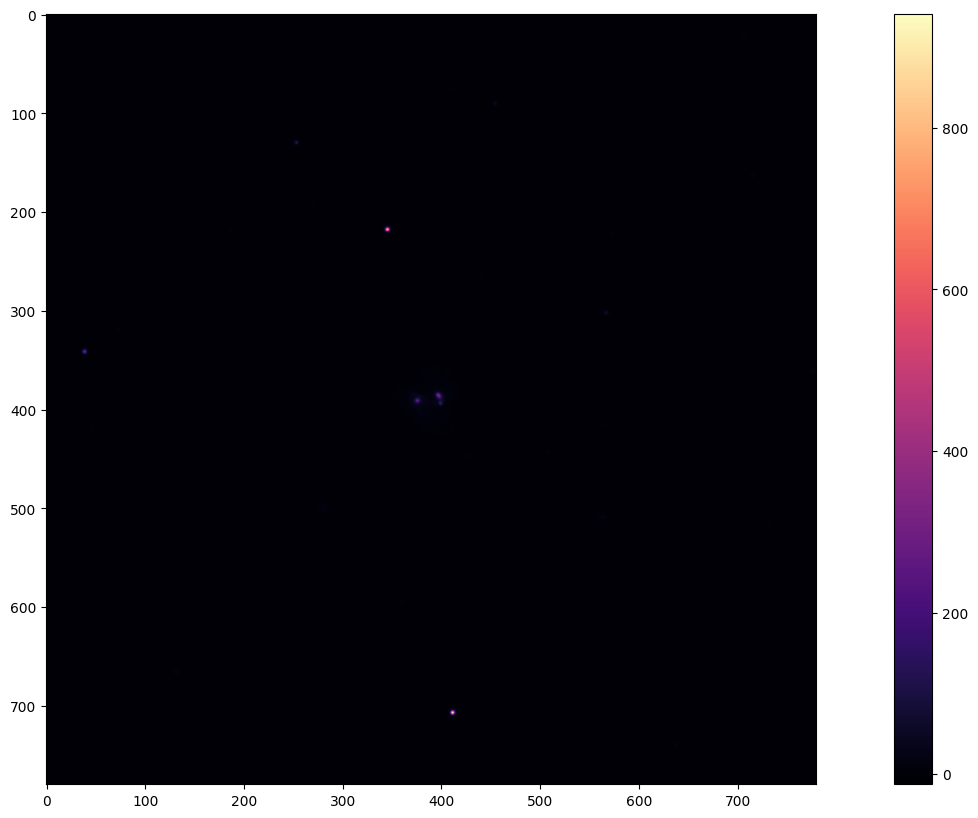

In [4]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
im = ax.imshow(cutimage,cmap="magma")
plt.colorbar(im, ax=ax)

plt.show() 

In [5]:
nparr = np.array(cutimage)
source = source_from_array(arr=nparr,sed="sne/sn1a",pixel_scale=0.066 ,amplitude=16,filter_curve="Ks")

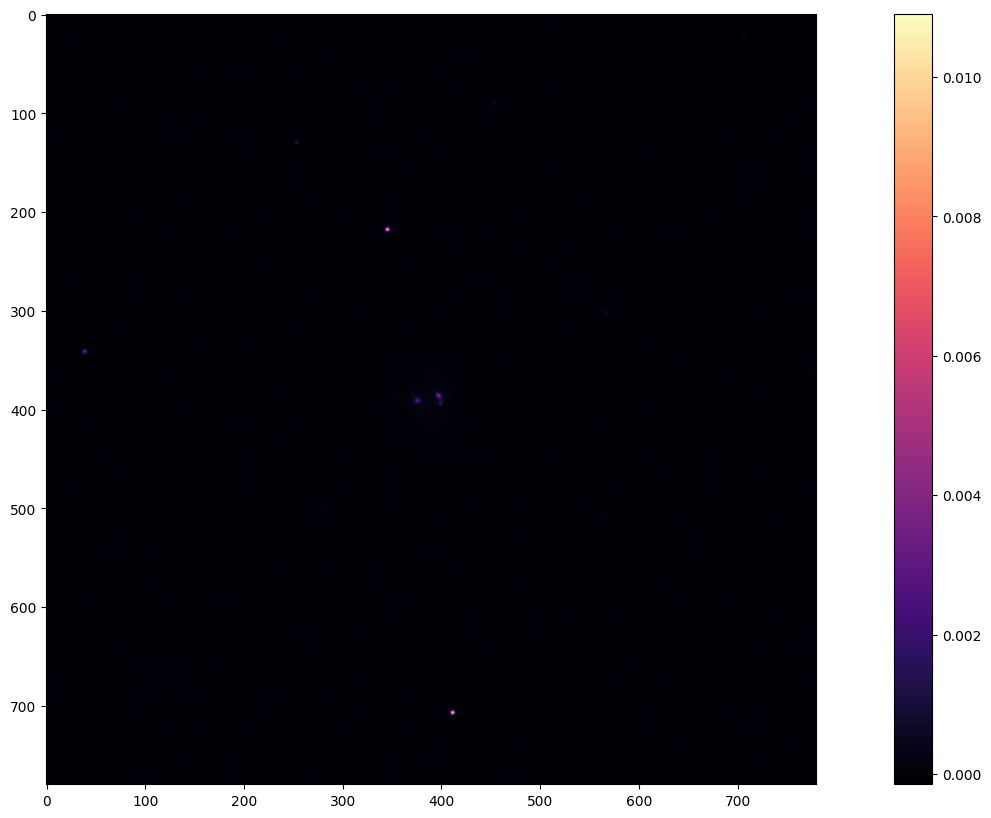

In [6]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
im = ax.imshow(source.fields[0].data,cmap="magma")
plt.colorbar(im, ax=ax)

plt.show() 


In [7]:
exposure_time = 1000

file_name = f"proffits_espt{exposure_time}"

sim.rc.__config__["!SIM.file.local_packages_path"] = ".\inst_pkgs\\"
yaml_dicts = []
with open("inst_pkgs\MICADO\default.yaml") as f:
    yaml_dicts += [dic for dic in yaml.full_load_all(f)]
mspec = yaml_dicts

In [8]:

cmds = sim.UserCommands(use_instrument="MICADO",
                    # mode_yamls=mspec,
                    set_modes=["SCAO","IMG_4mas"], #"SCAO", 
                    properties={"!OBS.dit": exposure_time,
                                #"!OBS.modes": ['MCAO', 'IMG_4mas'],
                                #"!OBS.airmass": 2.25,
                                #"!OBS.filter_name_fw1": "J",
                                #"!OBS.filter_name_fw2": "open",
                                #"!SIM.spectral.wave_mid": 1.578,
                                #"!SIM.spectral.spectral_resolution": 1/.00001,
                                #"!TEL.area" : 5000,
                                #"!TEL.pixel_scale" : 1,
                                #"!TEL.temperature" : 20,
                                #"!ATMO.humidity" : 0.8,
                                #"!ATMO.temperature" : 10,
                                #"!ATMO.pressure" : 1,
                                # "!DET.height": 2048,
                                # "!DET.width": 800
                                })

url: https://etimecalret-002.eso.org/observing/etc/api/skycalc,
data: {"airmass": 1.2, "pwv_mode": "pwv", "season": 0, "time": 0, "pwv": 2.5, "msolflux": 130.0, "incl_moon": "Y", "moon_sun_sep": 90.0, "moon_target_sep": 45.0, "moon_alt": 45.0, "moon_earth_dist": 1.0, "incl_starlight": "Y", "incl_zodiacal": "Y", "ecl_lon": 135.0, "ecl_lat": 90.0, "incl_loweratm": "Y", "incl_upperatm": "Y", "incl_airglow": "Y", "incl_therm": "N", "therm_t1": 0.0, "therm_e1": 0.0, "therm_t2": 0.0, "therm_e2": 0.0, "therm_t3": 0.0, "therm_e3": 0.0, "vacair": "vac", "wmin": 699.9999999999999, "wmax": 2499.9999999999995, "wgrid_mode": "fixed_spectral_resolution", "wdelta": 0.09999999999999999, "wres": 5000, "lsf_type": "none", "lsf_gauss_fwhm": 5.0, "lsf_boxcar_fwhm": 5.0, "observatory": "3060"},
timeout: 2
Response: {"status": "success", "tmpdir": "ffcd79f8-19e9-41ec-946b-0da2b3854a9b", "error": ""}

WARNING - Empty image HDU.
   element                 name             ... included
------------- ----------

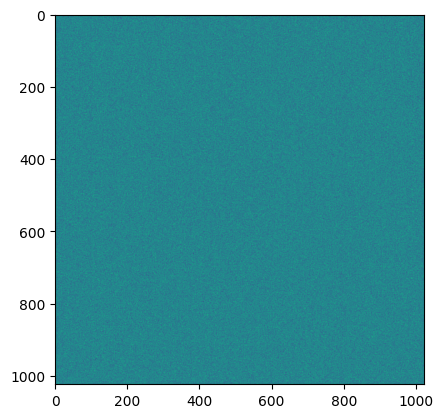

In [9]:



micado = sim.OpticalTrain(cmds)
micado.observe(source)
hdus = micado.readout(filename=f"fitsOutput/{file_name}.fits")
print(micado.effects)

plt.imshow(hdus[0][1].data)
plt.show()
try:
    os.remove(f"fitsOutput/spec_{file_name}.fits")
except:
    pass  
source.spectra[0].to_fits(f"fitsOutput/spec_{file_name}.fits", wavelengths=None, flux_unit=None, area=None,
                vegaspec=None)

In [24]:
source2 = source_from_file(filename='ngc3690_mosaic_k.fits',pixel_scale=0.67,sed="sne/sn1a",amplitude=15,filter_curve="Ks",ext=0)

In [28]:
source3 = point_source(sed="sne/sn1a",amplitude=15,filter_curve="Ks", x=0,y=0)

In [19]:
smallarr = np.zeros((10,10))
smallarr[1][2] = 2
smallarr[4][3] = 3
smallarr[5][5] = 1
smallarr[7][1] = 5
smallarr[9][1] = 3

In [21]:
def array_source(arr,totmag,spec,filtercurve,pixscale,maglim):
    totflux = sum(sum(arr))
    m2 = 0
    x0 = len(arr[0])/2
    y0 = len(arr)/2
    totsource = point_source(sed=spec,amplitude=50,filter_curve=filtercurve,x=0,y=0)
    F2lim = totflux*(10**(-0.4*(maglim-totmag)))
    for iy in range(len(arr)):
        for ix in range(len(arr[iy])):
            if arr[iy][ix] > F2lim:
                m2 = 2.5*np.log10(totflux/arr[iy][ix]) + totmag
                print(m2, iy, ix)
                totsource = totsource + point_source(sed=spec,amplitude=m2,filter_curve=filtercurve,x=(ix-x0)*pixscale,y=(iy-y0)*pixscale)
    return totsource



In [22]:
source = array_source(arr=smallarr,totmag=15,spec="sne/sn1a",filtercurve="Ks",pixscale=4,maglim=26)

17.112745100035642 1 2
16.67251695239644 4 3
17.865320089195595 5 5
16.11789507835555 7 1
16.67251695239644 9 1


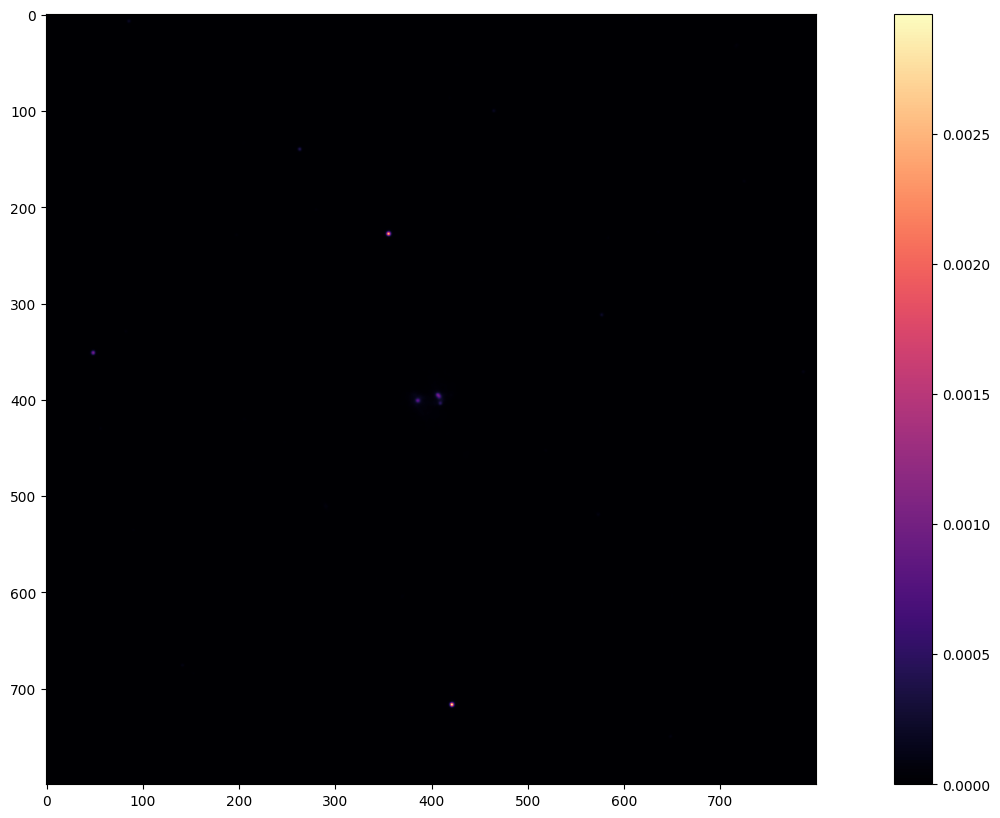

In [26]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
im = ax.imshow(source2.fields[0].data,cmap="magma")
plt.colorbar(im, ax=ax)

plt.show() 

url: https://etimecalret-002.eso.org/observing/etc/api/skycalc,
data: {"airmass": 1.2, "pwv_mode": "pwv", "season": 0, "time": 0, "pwv": 2.5, "msolflux": 130.0, "incl_moon": "Y", "moon_sun_sep": 90.0, "moon_target_sep": 45.0, "moon_alt": 45.0, "moon_earth_dist": 1.0, "incl_starlight": "Y", "incl_zodiacal": "Y", "ecl_lon": 135.0, "ecl_lat": 90.0, "incl_loweratm": "Y", "incl_upperatm": "Y", "incl_airglow": "Y", "incl_therm": "N", "therm_t1": 0.0, "therm_e1": 0.0, "therm_t2": 0.0, "therm_e2": 0.0, "therm_t3": 0.0, "therm_e3": 0.0, "vacair": "vac", "wmin": 699.9999999999999, "wmax": 2499.9999999999995, "wgrid_mode": "fixed_spectral_resolution", "wdelta": 0.09999999999999999, "wres": 5000, "lsf_type": "none", "lsf_gauss_fwhm": 5.0, "lsf_boxcar_fwhm": 5.0, "observatory": "3060"},
timeout: 2
Response: {"status": "success", "tmpdir": "4ded5872-8989-49eb-bc1f-79e451af0fda", "error": ""}

   element                 name             ... included
------------- ----------------------------- ... ---

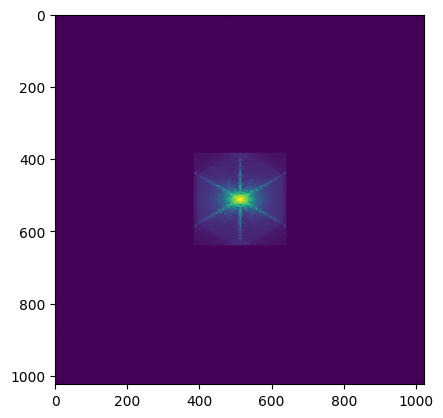

In [29]:
exposure_time = 1000

file_name = f"sample_point_espt{exposure_time}"

sim.rc.__config__["!SIM.file.local_packages_path"] = ".\inst_pkgs\\"
yaml_dicts = []
with open("inst_pkgs\MICADO\default.yaml") as f:
    yaml_dicts += [dic for dic in yaml.full_load_all(f)]
mspec = yaml_dicts

cmds = sim.UserCommands(use_instrument="MICADO",
                    # mode_yamls=mspec,
                    set_modes=["SCAO","IMG_4mas"], #"SCAO", 
                    properties={"!OBS.dit": exposure_time,
                                #"!OBS.modes": ['MCAO', 'IMG_4mas'],
                                #"!OBS.airmass": 2.25,
                                #"!OBS.filter_name_fw1": "J",
                                #"!OBS.filter_name_fw2": "open",
                                #"!SIM.spectral.wave_mid": 1.578,
                                #"!SIM.spectral.spectral_resolution": 1/.00001,
                                #"!TEL.area" : 5000,
                                #"!TEL.pixel_scale" : 1,
                                #"!TEL.temperature" : 20,
                                #"!ATMO.humidity" : 0.8,
                                #"!ATMO.temperature" : 10,
                                #"!ATMO.pressure" : 1,
                                # "!DET.height": 2048,
                                # "!DET.width": 800
                                })

micado = sim.OpticalTrain(cmds)
micado.observe(source3)
hdus = micado.readout(filename=f"fitsOutput/{file_name}.fits")
print(micado.effects)

plt.imshow(hdus[0][1].data)
plt.show()
try:
    os.remove(f"fitsOutput/spec_{file_name}.fits")
except:
    pass  
source.spectra[0].to_fits(f"fitsOutput/spec_{file_name}.fits", wavelengths=None, flux_unit=None, area=None,
                vegaspec=None)